In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from causal_nh.utils import open_pkl_file

%matplotlib inline

In [70]:
dataset_name = 'data_retweet_sampled'

In [73]:
path = f'../../data/NeuralHawkesData/{dataset_name}/'
# path = f'../../data/data_{dataset_name}/'

In [74]:
train = open_pkl_file(path + 'train.pkl', 'train')
dev = open_pkl_file(path + 'dev.pkl', 'dev')

In [75]:
from causal_nh.train_cuda import train_nh, train_causal_nh
from causal_nh.model.NeuralHawkesCuda import CausalNeuralHawkesMasked, CausalNeuralHawkesMaskedWeighted, CausalNeuralHawkesTrainableWeighted

Processing data...
CUDA is not Available. You are using CPU only.
Number of cores:  8
start training...
Epoch 0, process 0 out of 50 is done
Epoch 0, process 1 out of 50 is done
Epoch 0, process 2 out of 50 is done
Epoch 0, process 3 out of 50 is done
Epoch 0, process 4 out of 50 is done
Epoch 0, process 5 out of 50 is done
Epoch 0, process 6 out of 50 is done
Epoch 0, process 7 out of 50 is done
Epoch 0, process 8 out of 50 is done
Epoch 0, process 9 out of 50 is done
Epoch 0, process 10 out of 50 is done
Epoch 0, process 11 out of 50 is done
Epoch 0, process 12 out of 50 is done
Epoch 0, process 13 out of 50 is done
Epoch 0, process 14 out of 50 is done
Epoch 0, process 15 out of 50 is done
Epoch 0, process 16 out of 50 is done
Epoch 0, process 17 out of 50 is done
Epoch 0, process 18 out of 50 is done
Epoch 0, process 19 out of 50 is done
Epoch 0, process 20 out of 50 is done
Epoch 0, process 21 out of 50 is done
Epoch 0, process 22 out of 50 is done
Epoch 0, process 23 out of 50 is

('../../artefacts/2021_12_01_21_49_default_NeuralHawkes',
 '../../artefacts/2021_12_01_21_49_default_NeuralHawkes_model.pt')

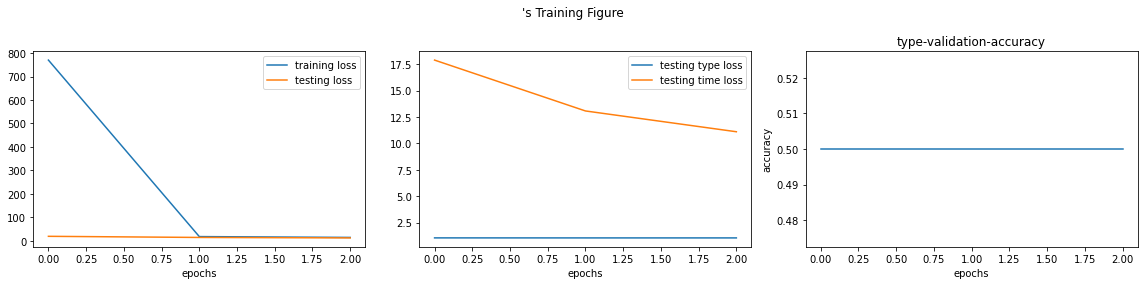

In [76]:
train_nh(train, dev, '../../artefacts/', False, lr=0.01, num_epochs=3, batch_size=10)

In [44]:
import pickle

In [45]:
with open(path + 'A.pkl', 'rb') as f:
    A = pickle.load(f)

In [46]:
A = A['A']
W = A
A[A==0.2] = 1


In [47]:
A

array([[1., 1., 1., 0., 0.],
       [1., 0., 1., 1., 1.],
       [1., 0., 1., 0., 1.],
       [0., 1., 0., 1., 1.],
       [0., 1., 0., 1., 1.]])

Processing data...
CUDA is not Available. You are using CPU only.
Number of cores:  8
start training...
The log-likelihood at epoch 0: -0.3649861939178353

validating on log likelihood...

validating on type prediction accuracy if we know when next event will happen...


The log-likelihood at epoch 1: 0.15944480573481953

validating on log likelihood...

validating on type prediction accuracy if we know when next event will happen...


The log-likelihood at epoch 2: 0.31829837596533384

validating on log likelihood...

validating on type prediction accuracy if we know when next event will happen...


Parameter containing:
tensor([[1.0888, 1.0743, 1.1214, 0.0000, 0.0000],
        [1.1040, 0.0000, 1.1381, 1.0352, 1.0657],
        [0.8752, 0.0000, 0.8571, 0.0000, 0.9394],
        [0.0000, 0.9005, 0.0000, 0.9513, 0.8924],
        [0.0000, 0.9005, 0.0000, 0.9513, 0.8924]], requires_grad=True)
tensor([[1., 1., 1., 0., 0.],
        [1., 0., 1., 1., 1.],
        [1., 0., 1., 0., 1.],
        [

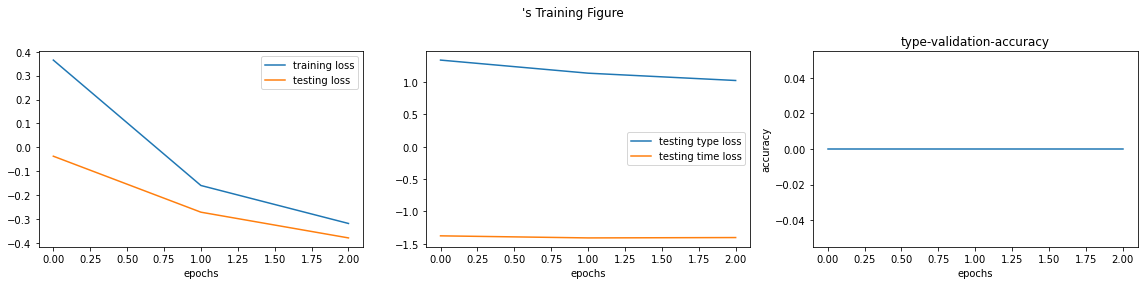

Saving training loss and validation data...
If you have a trained model before this, please combine the previous train_date file to generate plots that are able to show the whole training information


In [48]:
save_path, model_path = train_causal_nh(train, dev, A,W, 
                        '../../artefacts/', False, lr=0.01, num_epochs=3,
                batch_size=50, dataset_name=dataset_name, model=CausalNeuralHawkesTrainableWeighted)

In [49]:
print((save_path, model_path))

('../../artefacts/2021_12_00_45_45_synth_5_events_small_CausalNeuralHawkesTrainableWeighted', '../../artefacts/2021_12_00_45_45_synth_5_events_small_CausalNeuralHawkesTrainableWeighted_model.pt')


In [50]:
from causal_nh.test import test_prediction

In [63]:
test_data = open_pkl_file(path + 'test.pkl', 'test')



In [69]:
test_data[1]

[tensor([0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         1, 0, 0, 1, 1, 1, 0, 0, 0]),
 tensor([1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
         1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0]),
 tensor([0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
         1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0]),
 tensor([1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
         0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]),
 tensor([0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
         0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
         1, 0]),
 tensor([0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
         1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1]),
 tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0

In [52]:
path_to_init = save_path

prediction at event 10 on a sequence of length 73 is done
prediction at event 11 on a sequence of length 73 is done
prediction at event 12 on a sequence of length 73 is done
prediction at event 13 on a sequence of length 73 is done
prediction at event 14 on a sequence of length 73 is done
prediction at event 15 on a sequence of length 73 is done
prediction at event 16 on a sequence of length 73 is done
prediction at event 17 on a sequence of length 73 is done
prediction at event 18 on a sequence of length 73 is done
prediction at event 19 on a sequence of length 73 is done
prediction at event 20 on a sequence of length 73 is done
prediction at event 21 on a sequence of length 73 is done
prediction at event 22 on a sequence of length 73 is done
prediction at event 23 on a sequence of length 73 is done
prediction at event 24 on a sequence of length 73 is done
prediction at event 25 on a sequence of length 73 is done
prediction at event 26 on a sequence of length 73 is done
prediction at 

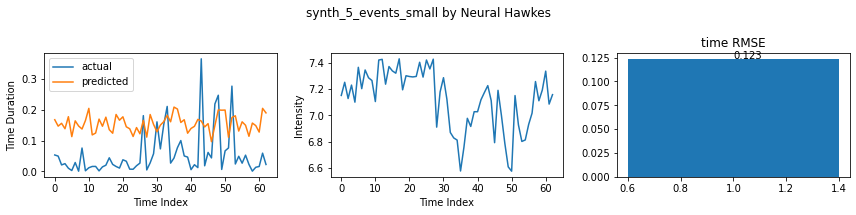

        time  events  time_est  events_est  time_since_start  \
0   0.052965       0  0.167576           2          0.052965   
1   0.049269       1  0.146737           2          0.102235   
2   0.020625       0  0.155949           2          0.122860   
3   0.024772       1  0.138287           2          0.147631   
4   0.009907       0  0.177443           2          0.157538   
..       ...     ...       ...         ...               ...   
58  0.000362       0  0.156688           2          3.362579   
59  0.012958       0  0.148418           2          3.375536   
60  0.015574       0  0.127360           2          3.391110   
61  0.058855       0  0.204514           2          3.449965   
62  0.022064       0  0.189777           2          3.472029   

    time_since_start_est  
0               0.167576  
1               0.199703  
2               0.258184  
3               0.261147  
4               0.325074  
..                   ...  
58              3.518905  
59             

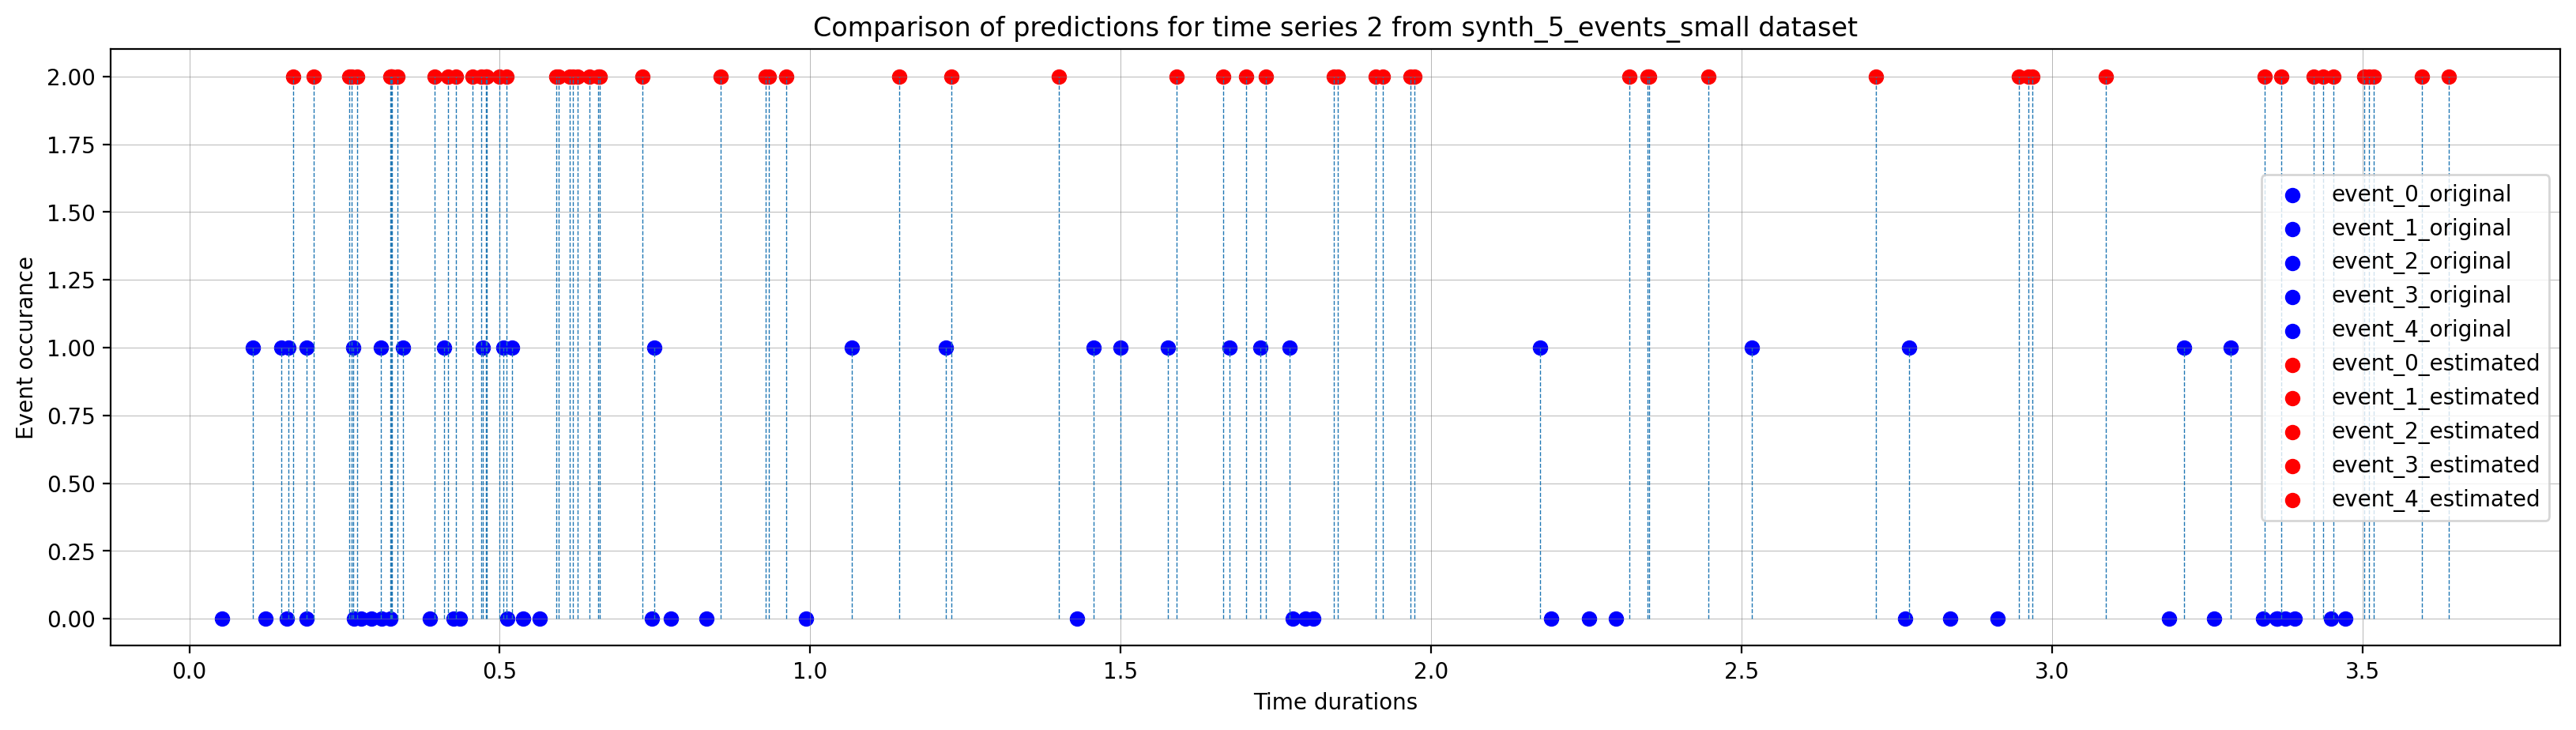

In [57]:
original_time, original_type, estimated_times, estimated_types, estimated_intensities = test_prediction(
                test_data = test_data,
                idx_test_series=2,
                n_samples=1000,
                start_test_idx=10,
                path_to_initialization=path_to_init,
                dataset_name=dataset_name)

In [38]:
test_data

([tensor([0.1909, 0.2206, 0.1444, 0.4181, 0.0701, 0.0569, 0.0424, 0.3408, 2.0748,
          0.1859, 0.1662, 0.0993, 0.0371, 0.0064, 0.4840, 0.7504, 0.3354, 0.0178,
          0.8496]),
  tensor([0.1636, 0.4003, 0.3808, 0.1562, 0.1401, 0.1764, 0.0902, 0.0218, 0.0789,
          0.0909, 0.0813, 0.0158, 0.1173, 0.0090, 0.6739, 0.0752, 1.3050, 0.0399,
          0.2505, 0.2645, 0.9649, 0.7993, 0.2179, 0.1855]),
  tensor([0.1092, 1.1369, 0.0505, 0.2245, 0.1000, 0.0518, 0.1386, 0.1934, 0.5376,
          0.3486, 0.4516, 0.1533, 0.2941, 0.6589, 0.0233, 0.5624, 0.0551, 0.1173,
          0.3723, 0.4836, 0.0352, 0.0266, 0.0687, 0.0223, 0.0226, 0.0838, 0.0051,
          0.1211, 0.4236, 0.0368, 0.2549, 0.0311, 0.9913, 0.1107, 0.0960, 0.3600]),
  tensor([0.0663, 0.1210, 0.1228, 0.1613, 0.7603, 0.4422, 0.1837, 0.2000, 1.6964,
          0.0233, 0.1542, 0.1207, 0.2306, 0.2102, 0.7142, 1.0469, 0.2789, 0.4434,
          0.2163, 0.0477]),
  tensor([0.0096, 0.0930, 0.2453, 0.0443, 0.3176, 1.4686, 0.2068, 0.15